In [34]:
!pip install pmdarima

In [35]:
import itertools
import math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime
# import quandl
import matplotlib.pylab as plt

from statsmodels.tsa.stattools import coint, adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from pmdarima.arima import auto_arima

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense,LSTM
# import tensorflow.keras
# import tensorflow
# mlflow.tensorflow.autolog

# import mlflow
import sklearn.tree 
import sklearn
#import DecisionTreeRegressor

np.random.seed(0)
import time
start_time = time.time()

In [36]:
df = pd.read_csv('daily_timeframe')

In [37]:
df = df[(df['start_time'] > '2022-01-01')]
df = df.set_index('start_time')
df.index = pd.to_datetime(df.index).to_period('D')
df = df[df['symbol'] == "BTC-USDT"]
df1 = df[['opening_price']]
df1 = df1.sort_index()

AUTOARIMA

In [38]:
#import scipy.stats
#import pylab
#scipy.stats.probplot(B_DF['Brand PDE Count'], plot = pylab)
#plt.title("QQ Plot", size = 24)
#pylab.show()

#B_DF['Brand PDE Count'].plot(figsize=(15, 6))
#plt.show()

from pylab import rcParams
#rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df1, period = 24)
fig = decomposition#.plot()
#plt.show()

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

arima_model =  auto_arima(df1,
                          start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, 
                          start_P=5, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=12, 
                          seasonal=True, error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True, random_state=20,n_fits = 50 )

arima_model.summary()

df_order = [arima_model.order]
df_s_order = [arima_model.seasonal_order]

#Best AIC NEW
mod = sm.tsa.statespace.SARIMAX(df1['opening_price'],
                                order= (df_order[0]),
                                seasonal_order= (df_s_order[0]),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_B = mod.fit()
print(results_B.summary().tables[1])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=2145.738, Time=7.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2160.683, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2150.605, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2148.005, Time=0.28 sec
 ARIMA(0,1,0)(4,1,0)[12]             : AIC=2154.248, Time=1.43 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=inf, Time=12.76 sec
 ARIMA(0,1,0)(4,1,1)[12]             : AIC=inf, Time=8.19 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=2151.026, Time=3.39 sec
 ARIMA(0,1,1)(5,1,0)[12]             : AIC=2151.509, Time=3.18 sec
 ARIMA(1,1,1)(5,1,0)[12]             : AIC=2153.505, Time=3.35 sec
 ARIMA(0,1,0)(5,1,0)[12] intercept   : AIC=2150.656, Time=2.85 sec

Best model:  ARIMA(0,1,0)(5,1,0)[12]          
Total fit time: 42.857 seconds
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

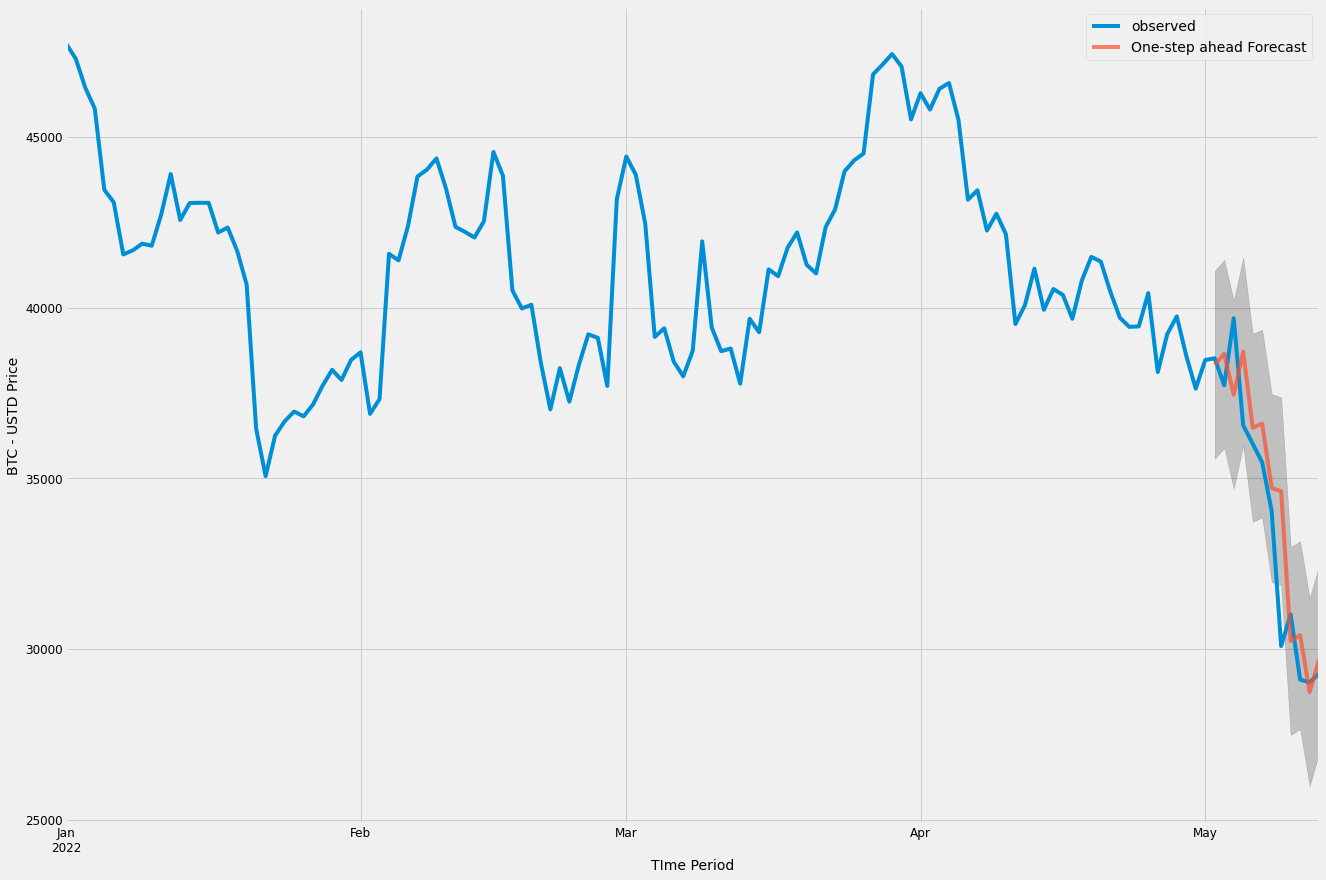

In [39]:
#Best AIC
pred = results_B.get_prediction(start=pd.to_datetime('2022-05-02'), dynamic=False)
pred_ci = pred.conf_int()

ax = df1['opening_price']['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(20, 14))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('TIme Period')
ax.set_ylabel('BTC - USTD Price')
plt.legend()
plt.show()

pred_ci['AUTOARIMA Prediction - opening_price'] = pred_ci[['lower opening_price', 'upper opening_price']].mean(axis=1)
pred_ci = pred_ci.drop(['lower opening_price', 'upper opening_price'], axis=1)
df = pd.merge(df,pred_ci,how='left',left_index=True, right_index=True)

y_actual = df1['opening_price'][df1.index[-12]:]
y_predicted = pred_ci['AUTOARIMA Prediction - opening_price']
from sklearn.metrics import mean_squared_error
rms_autoarima = mean_squared_error(y_actual, y_predicted, squared=False)
mape_autoarima = sklearn.metrics.mean_absolute_percentage_error(y_actual, y_predicted) * 100

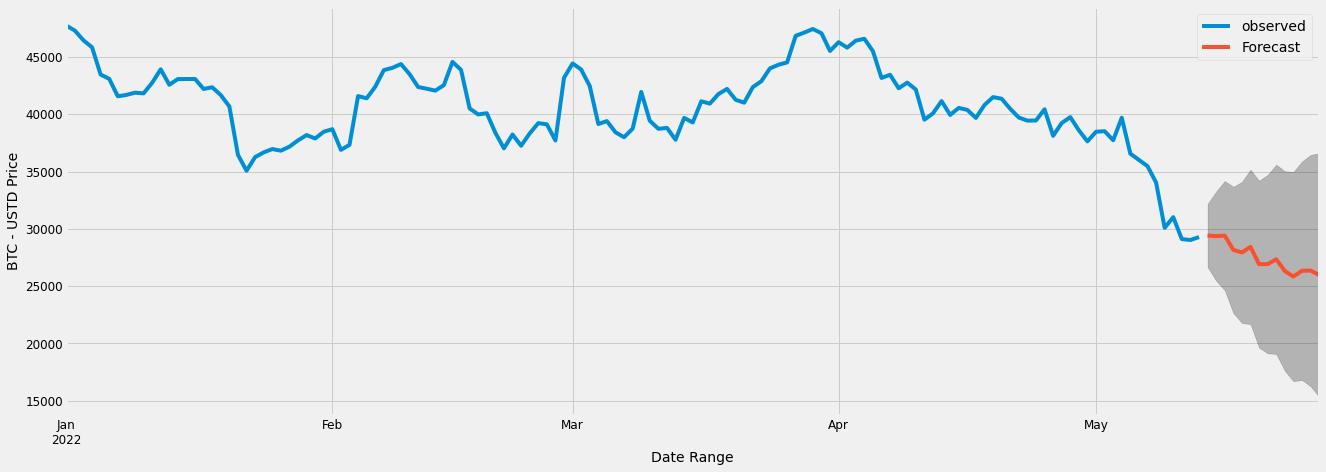

In [40]:
pred_uc = results_B.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()

ax = df1['opening_price'].plot(label='observed', figsize=(20, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date Range')
ax.set_ylabel('BTC - USTD Price')
plt.legend()
plt.show()

pred_ci['AUTOARIMA Forecast - opening_price'] = pred_ci[['lower opening_price', 'upper opening_price']].mean(axis=1)
pred_ci = pred_ci.drop(['lower opening_price', 'upper opening_price'], axis=1)
df = pd.concat([df,pred_ci], axis = 1)

In [41]:
df.head()

,symbol,opening_price,closing_price,highest_price,lowest_price,transaction_amount,transaction_volume,AUTOARIMA Prediction - opening_price,AUTOARIMA Forecast - opening_price
2022-01-01,BTC-USDT,47728.6,47291.8,47990.0,46656.1,4870.849832,2.301852e+08,NaN,NaN
2022-01-02,BTC-USDT,47291.7,46443.4,47577.0,45700.0,6995.618632,3.266873e+08,NaN,NaN
2022-01-03,BTC-USDT,46443.4,45833.0,47529.0,45555.0,8422.083278,3.913423e+08,NaN,NaN
2022-01-04,BTC-USDT,45833.0,43456.8,47052.4,42500.0,14203.264918,6.425458e+08,NaN,NaN
2022-01-05,BTC-USDT,43456.2,43086.1,43817.3,42420.0,9798.801801,4.222144e+08,NaN,NaN


In [42]:
mape_autoarima

3.7932406319392036